---
title: Reproducing Chen et. al. (2021)'s unsupervised machine learning
subtitle: Using UMAP to reduce dimensions and HDBSCAN to cluster datapoints
author: Murthadza Aznam
date: '2022-10-20'
---

:::{.callout-note}

 📌 Goal: This notebook tries to reproduce the results from [https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.1227C/abstract](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.1227C/abstract)

:::

## 0. Requirements
The paper uses data from CHIME/FRB Catalog. Luckily, the CHIME/FRB team has made it simple for us to access their data through the [CHIME/FRB Open Data](https://github.com/chime-frb-open-data/chime-frb-open-data) package, `cfod`.

In [5]:
import pandas as pd

cat: pd.DataFrame = pd.read_csv('../data/raw/chimefrbcat1_Hashimoto_2022.csv')
a=[print(col) for col in cat.columns]

tns_name
previous_name
repeater_name
ra
ra_err
ra_notes
dec
dec_err
dec_notes
gl
gb
exp_up
exp_up_err
exp_up_notes
exp_low
exp_low_err
exp_low_notes
bonsai_snr
bonsai_dm
low_ft_68
up_ft_68
low_ft_95
up_ft_95
snr_fitb
dm_fitb
dm_fitb_err
dm_exc_ne2001
dm_exc_ymw16
bc_width
scat_time
scat_time_err
flux
flux_err
flux_notes
fluence
fluence_err
fluence_notes
sub_num
mjd_400
mjd_400_err
mjd_inf
mjd_inf_err
width_fitb
width_fitb_err
sp_idx
sp_idx_err
sp_run
sp_run_err
high_freq
low_freq
peak_freq
chi_sq
dof
flag_frac
excluded_flag
subw_upper_flag
scat_upper_flag
spec_z
spec_z_flag
E_obs
E_obs_error
subb_flag
subb_p_flag
common_p_flag
delta_nuo_FRB
z_DM
z_DM_error_p
z_DM_error_m
E_obs_400
E_obs_400_error_p
E_obs_400_error_m
logsubw_int_rest
logsubw_int_rest_error_p
logsubw_int_rest_error_m
z
z_error_p
z_error_m
logE_rest_400
logE_rest_400_error_p
logE_rest_400_error_m
logrhoA
logrhoA_error_p
logrhoA_error_m
logrhoB
logrhoB_error_p
logrhoB_error_m
weight_DM
weight_DM_error_p
weight_DM_error_m
w

## 0.1 Parameters

### 0.1.1 Observational Parameters
The parameters selected by the paper is as follows:
- Boxcar Width
- Width of Sub-Burst
- Flux
- Fluence
- Scattering Time
- Spectral Index
- Spectral Running
- Highest Frequency
- Lowest Frequency
- Peak Frequency

### 0.1.2 Model Dependent Parameters
- Redshift `z`
- Radio Energy `logE_rest_400`
- Rest-Frame Intrinsic Duration `logsubw_int_rest`

In [11]:
from typing import Type


params : Type[str] = [
    # Observational
    "bc_width",
    "width_fitb",
    "flux",
    "scat_time",
    "sp_idx",
    "sp_run",
    "high_freq",
    "low_freq",
    "peak_freq",
    # Model dependent
    "z",
    "logE_rest_400",
    "logsubw_int_rest"
]

selected = cat[params].dropna()
selected

,bc_width,width_fitb,flux,scat_time,sp_idx,sp_run,high_freq,low_freq,peak_freq,z,logE_rest_400,logsubw_int_rest
0,0.00295,0.00030,2.0,0.001100,38.0,-46.0,760.1,485.3,607.4,0.676253,40.208078,-0.748199
1,0.00295,0.00140,0.6,0.001700,4.0,-9.0,800.2,400.2,493.3,0.662998,39.791080,-0.073706
2,0.00098,0.00010,12.0,0.000157,16.5,-30.2,692.7,400.2,525.6,0.067419,38.880719,-0.948762
3,0.00197,0.00031,0.9,0.000700,14.0,-15.0,800.2,441.8,657.5,0.189369,38.561879,-0.582195
4,0.00492,0.00047,5.0,0.002070,4.3,-11.3,759.2,400.2,483.5,0.839657,41.127444,-0.592583
...,...,...,...,...,...,...,...,...,...,...,...,...
594,0.00197,0.00061,1.3,0.000720,-1.0,3.0,800.2,400.2,800.2,0.622526,39.639959,-0.423913
595,0.00295,0.00060,1.1,0.000300,4.0,-12.0,732.8,400.2,471.5,0.736153,39.870346,-0.463004
596,0.00197,0.00140,0.9,0.001800,46.0,-210.0,495.5,402.2,446.4,0.971651,40.362724,-0.148206
597,0.00885,0.00140,1.3,0.001500,6.5,-21.0,651.8,400.2,467.6,0.937864,40.835803,-0.141426


In [12]:
import umap

In [17]:
map = umap.UMAP(n_neighbors=8, n_components=2).fit(selected)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot: >

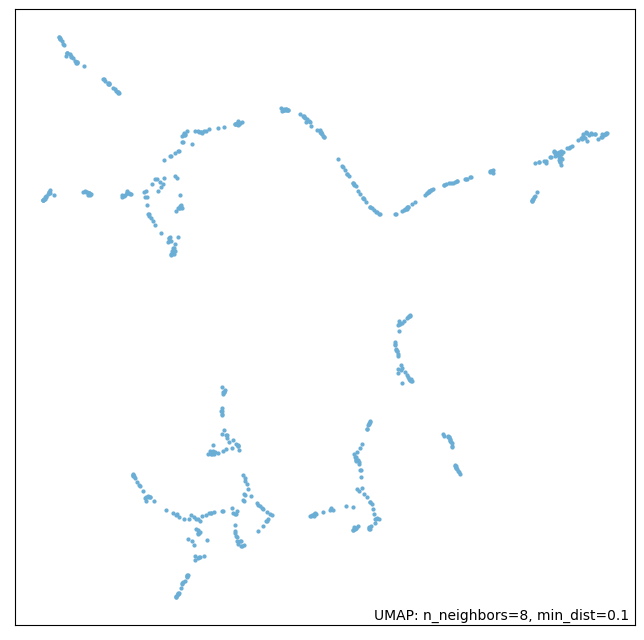

In [18]:
from umap import plot

plot.points(map)